- Thực nghiệm với 37 classes


## Imports and Setups

In [ ]:
!pip install -qq wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
import wandb
from wandb.keras import WandbMetricsLogger
from wandb.keras import WandbEvalCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import keras

import tensorflow_datasets as tfds

import os
import numpy as np
from argparse import Namespace
import matplotlib.pyplot as plt

In [ ]:
configs = Namespace(
    img_size = 128,
    batch_size = 32,
    num_classes = 39,
)
configs

Namespace(img_size=128, batch_size=32, num_classes=39)

# Dataloader

We will be using Oxford Pets Dataset which we can directly get from TensorFlow Datasets.

In [ ]:
train_ds, valid_ds = tfds.load('oxford_iiit_pet', split=["train", "test"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete021D96/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete021D96/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
# def labelling(sample):  
#   img = sample["image"].numpy()
#   label = sample["label"].numpy()
#   mask = sample["segmentation_mask"].numpy()

#   for i in range(mask.shape[0]):
#     for j in range(mask.shape[1]):
#       if mask[i][j] == 1:
#           mask[i][j] = sample["label"]
#   return mask

In [ ]:
train_ds

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

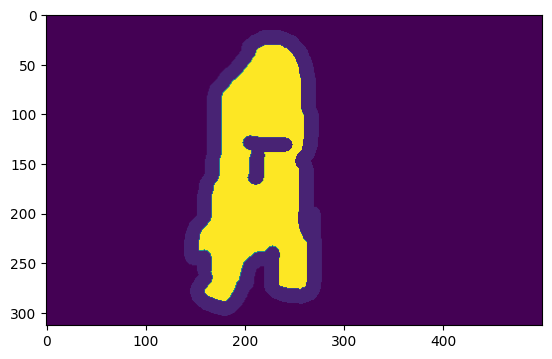

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#img = mpimg.imread('your_image.png')
imgplot = plt.imshow(sample["segmentation_mask"])
plt.show()

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def parse_data(example):
    # Parse image
    image = example["image"]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=(configs.img_size, configs.img_size))

    # Parse mask
    label = example["label"]
    mask = example["segmentation_mask"] # ground truth labels are [1,2,3].
    # mask = tf.image.convert_image_dtype(mask, tf.int64)

    mask = tf.image.resize(mask, size=(configs.img_size, configs.img_size), method='nearest')
    mask = tf.one_hot(tf.squeeze(mask, axis=-1), depth=configs.num_classes)

    # for i in range(mask.shape[0]):
    #   for j in range(mask.shape[1]):
    #     if mask[i][j] == 0:
    #       mask[i][j] = label

    return image, mask

trainloader = (
    train_ds
    .shuffle(1024)
    .map(parse_data, num_parallel_calls=AUTOTUNE)
    .batch(configs.batch_size)
    .prefetch(AUTOTUNE)
)

validloader = (
    valid_ds
    .map(parse_data, num_parallel_calls=AUTOTUNE)
    .batch(configs.batch_size)
    .prefetch(AUTOTUNE)
)

## Model

In [ ]:
# ref: https://github.com/ayulockin/deepimageinpainting/blob/master/Image_Inpainting_Autoencoder_Decoder_v2_0.ipynb
class SegmentationModel:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(configs.img_size, configs.img_size, 3)):
        inputs = layers.Input(input_size)

        conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs)
        conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2)
        conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3)
        
        conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
        
        outputs = layers.Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv9)

        return models.Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
          pool = layers.MaxPooling2D(pool_size)(conv)
          return conv, pool
        else:
          return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = layers.concatenate([up, shared_layer], axis=3)

        return conv, up

#### Initialize Model and Compile

In [ ]:
configs.num_classes

39

In [ ]:
# output channel is 3 because we have three classes in our mask
tf.keras.backend.clear_session()
model = SegmentationModel().prepare_model(configs.num_classes)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

## Design FCN

In [ ]:
inputs = keras.Input(shape=(configs.img_size, configs.img_size, 3))
x = keras.layers.Dense(784, activation=tf.nn.relu)(inputs)
x = keras.layers.Dense(512, activation=tf.nn.relu)(x)
x = keras.layers.Dense(256, activation=tf.nn.relu)(x)
x = keras.layers.Dense(128, activation=tf.nn.relu)(x)
outputs = keras.layers.Dense(39, activation=tf.nn.softmax)(x)

FCN_model = keras.Model(inputs, outputs)

In [ ]:
# output channel is 3 because we have three classes in our mask
keras.backend.clear_session()
# model = SegmentationModel().prepare_model(configs.num_classes)

FCN_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
)

FCN_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 dense (Dense)               (None, 128, 128, 784)     3136      
                                                                 
 dense_1 (Dense)             (None, 128, 128, 512)     401920    
                                                                 
 dense_2 (Dense)             (None, 128, 128, 256)     131328    
                                                                 
 dense_3 (Dense)             (None, 128, 128, 128)     32896     
                                                                 
 dense_4 (Dense)             (None, 128, 128, 39)      5031      
                                                                 
Total params: 574,311
Trainable params: 574,311
Non-trainab

## Callback

In [ ]:
segmentation_classes = ['pet', 'pet_outline', 'background'] 
# segmentation_classes = ['Abyssinian', 'Bengal', 'Bombay', 'Birman', 'British Shorthair', 'Maine Coon',
#                         'Persian', 'Egyptian Mau', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx',
#                         'Boxer', 'Keeshond', 'Havanese', 'Basset Hound', 'English Setter', 'Miniature Pinscher',
#                         'Chihuahua', 'Great Pyrenees', 'German Shorthaired', 'Beagle', 'Staffordshire Bull Terrier',
#                         'English Cocker Spaniel', 'New Found Land', 'Pomeranian', 'Leonberger',
#                         'American Pit Bull Terrier', 'Wheaten Terrier', 'Japanese Chin', 'Samyod',
#                         'Scottish Terrier', 'Shiba Inu', 'Pug', 'Saint Bernard', 'American Bulldog',
#                         'Yorkshire Terrier','pet_outline', 'background'] 

# returns a dictionary of labels
def labels():
    l = {}
    for i, label in enumerate(segmentation_classes):
        l[i] = label
    return l

In [ ]:
class WandbSemanticLogger(WandbEvalCallback):
    def __init__(
        self,
        validloader,
        data_table_columns=["index", "image"],
        pred_table_columns=["epoch", "index", "image", "prediction"],
        num_samples=100,
    ):
        super().__init__(
            data_table_columns,
            pred_table_columns,
        )

        self.val_data = validloader.unbatch().take(num_samples)

    def add_ground_truth(self, logs):
        for idx, (image, mask) in enumerate(self.val_data):
            self.data_table.add_data(
                idx,
                self._prepare_wandb_mask(
                    image.numpy(),
                    np.argmax(mask.numpy(), axis=-1),
                    "ground_truth"
                )
            )

    def add_model_predictions(self, epoch, logs):
        data_table_ref = self.data_table_ref
        table_idxs = data_table_ref.get_index()

        for idx, (image, mask) in enumerate(self.val_data):
            prediction = self.model.predict(tf.expand_dims(image, axis=0), verbose=0)
            prediction = np.argmax(tf.squeeze(prediction, axis=0).numpy(), axis=-1)

            self.pred_table.add_data(
                epoch,
                data_table_ref.data[idx][0],
                self._prepare_wandb_mask(
                    data_table_ref.data[idx][1],
                    np.argmax(mask.numpy(), axis=-1),
                    "ground_truth"
                ),
                self._prepare_wandb_mask(
                    data_table_ref.data[idx][1],
                    prediction,
                    "prediction"
                )
            )

    def _prepare_wandb_mask(self, image, mask, mask_type):
        return wandb.Image(
            image,
            masks = {
                "ground_truth": {
                    "mask_data": mask,
                    "class_labels": labels()
            }})

## Train

In [ ]:
run = wandb.init(project='image-segmentation', config=configs)

_ = model.fit(
    trainloader, 
    epochs=10, 
    validation_data=validloader,
    callbacks=[
        WandbMetricsLogger(log_freq=2),
        WandbSemanticLogger(validloader)
      ]
    )

run.finish()

wandb: Currently logged in as: 20520435. Use `wandb login --relogin` to force relogin


wandb:   202 of 202 files downloaded.  


Epoch 1/10
  6/115 [>.............................] - ETA: 18s - loss: 4.4181

115/115 [==============================] - 76s 420ms/step - loss: 1.2709 - val_loss: 0.8063
Epoch 2/10
115/115 [==============================] - 54s 442ms/step - loss: 0.7396 - val_loss: 0.6867
Epoch 3/10
115/115 [==============================] - 48s 403ms/step - loss: 0.6756 - val_loss: 0.6645
Epoch 4/10
115/115 [==============================] - 48s 402ms/step - loss: 0.6364 - val_loss: 0.5931
Epoch 5/10
115/115 [==============================] - 50s 407ms/step - loss: 0.5808 - val_loss: 0.5487
Epoch 6/10
115/115 [==============================] - 53s 443ms/step - loss: 0.5129 - val_loss: 0.5100
Epoch 7/10
115/115 [==============================] - 48s 397ms/step - loss: 0.4812 - val_loss: 0.4582
Epoch 8/10
115/115 [==============================] - 48s 400ms/step - loss: 0.4438 - val_loss: 0.4398
Epoch 9/10
115/115 [==============================] - 49s 393ms/step - loss: 0.4190 - val_loss: 0.4124
Epoch 10/10
115/115 [==============================] - 49s 410ms/step - loss: 0.3888

batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▂▂▁▁▁
epoch/val_loss,█▆▆▄▄▃▂▂▁▁
batch/batch_step,1158
batch/learning_rate,0.001
batch/loss,0.3888
epoch/epoch,9


In [ ]:
# run = wandb.init()
# artifact = run.use_artifact('20520435/image-segmentation/run_hufsjsmq_pred:v6', type='evaluation')
# artifact_dir = artifact.download()

wandb:   302 of 302 files downloaded.  


Truy cập :
https://wandb.ai/20520435/image-segmentation/artifacts/evaluation/run_hufsjsmq_pred/v7/files/eval_data.table.json